# EM-algorithms in Gaussian mixture model

In [117]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tqdm import tqdm

tfd = tfp.distributions

In [118]:
# for reproducibility
np.random.seed(52)
tf.random.set_seed(1234)
# set style
plt.style.use("ggplot")

## [Gaussian mixture model](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model)
We have a mixture of Gaussian distrubtions, with observed data $\textbf X =(x_1,...x_n)$ and latend variable $\textbf Z =(z_1,...,z_m)$  (class of the observed data).<br/>
\begin{align}
\textbf{Z} &\sim Cat(\pi) \\
\textbf{X} &\sim \mathcal{N} (\mu,\sigma)
\end{align}
<br/>
With the exmaple here,  $\textbf Z$ is two-class mixture of Gaussian distribution. Small vertical lines are observed data $\textbf X$. Color represents the class, which is only for visualziation but unknow in practice.



In [119]:
# we take 1D two-class Gaussian mixture model as an example
# true values for generating data
true_pis = [0.25, 0.75]
true_mus = [2.0, 5.0]
true_sigmas = [1.0, 1.8]
sample_size = 1000

In [120]:
# two-class categorical distributions
states = tfd.Categorical(probs=true_pis).sample(sample_size).numpy()
# Bernoullie also works for 2-class situation
# states = tfd.Bernoulli(probs=0.75).sample(sample_size).numpy()
Gaussian_models = [tfd.Normal(loc=2.0, scale=1.0), tfd.Normal(loc=5.0, scale=1.8)]
# sample with known class for plotting
x = np.array([Gaussian_models[g].sample().numpy() for g in states])

In [138]:
# # a simpler way to generate distirbutin, but not able to show the latent class of sampled data.
# univariate_gmm = tfd.MixtureSameFamily(
#     mixture_distribution=tfd.Categorical(probs=true_pis),
#     components_distribution=tfd.Normal(loc=true_mus, scale=true_sigmas),
# )
# # x1 = univariate_gmm.sample(sample_size).numpy()
# plt.plot(
# xx, univariate_gmm.prob(xx), label='GMM',ls="dashed", alpha=0.5
# )
# plt.legend()
# plt.show()

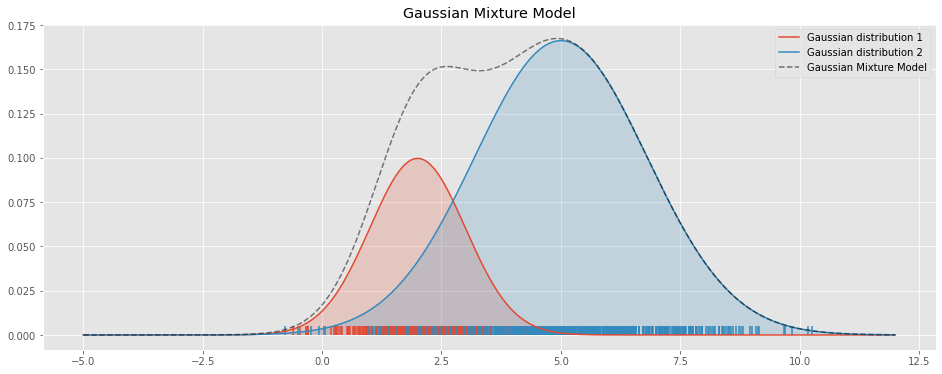

In [122]:
# plot the sample data
xx = np.linspace(-5, 12, 1000)
plt.figure(figsize=(16, 6))
plt.title("Gaussian Mixture Model")
plt.plot(xx, Gaussian_models[0].prob(xx) * true_pis[0], label="Gaussian distribution 1")
plt.plot(xx, Gaussian_models[1].prob(xx) * true_pis[1], label="Gaussian distribution 2")
plt.plot(
    xx,
    (
        Gaussian_models[0].prob(xx) * true_pis[0]
        + Gaussian_models[1].prob(xx) * true_pis[1]
    ),
    label="Gaussian Mixture Model",
    ls="dashed",
    color="black",
    alpha=0.5,
)
# plt.plot(
#     xx, univariate_gmm.prob(xx), label="mixturemodel generation", ls="dashed", alpha=0.5
# )
plt.fill_betweenx(Gaussian_models[0].prob(xx) * true_pis[0], xx, alpha=0.2)
plt.fill_betweenx(Gaussian_models[1].prob(xx) * true_pis[1], xx, alpha=0.2)
plt.vlines(x, 0, 0.005, color=np.array(["C0", "C1"])[states])
plt.legend()
plt.show()

## [EM-algorithm](https://en.wikipedia.org/wiki/EM_algorithm_and_GMM_model)
Evaluate the parameters for the Gaussian distributions with observed data $\textbf X$ by integrating out latend variables $\textbf Z$. 
We want to maximize $ l(\boldsymbol{\theta}) =\sum_{i=0}^{N-1} log p(x_i;\boldsymbol{\theta})$, where  $\boldsymbol{\theta} = (\pi,\mu,\sigma)$.
<br/>

_Here is the derivation of EM-algorithms for general case:_


\begin{align}
l(\boldsymbol{\theta})&=\sum_{i=0}^{N-1} log p(x_i;\boldsymbol{\theta})\\
&=\sum_{i=0}^{N-1}log \sum_{j=0}^{M-1}p(x_i,z_j;\boldsymbol{\theta})\\
&=\sum_{i=0}^{N-1}log \sum_{j=0}^{M-1} q(z_j)\frac{p(x_i,z_j;\boldsymbol{\theta})}{q(z_j)}\\
&=\sum_{i=0}^{N-1}log \mathbb{E}_{z_j \sim q(z)}\frac{p(x_i,z_j;\boldsymbol{\theta})}{q(z_j)}\\
&\leq ^{Jensen's inequality} \mathbb{E}_{z_j \sim q(z)} log \frac{p(x_i,z_j;\boldsymbol{\theta})}{q(z_j)} \\
&=\sum_{i=0}^{N-1}\sum_{j=0}^{M-1} q(z_j)log \frac{p(x_i,z_j;\boldsymbol{\theta})}{q(z_j)} 
\end{align}

Let $q(z_j)$ be the posterior $p(z_j|x_i;\boldsymbol{\theta})$:


\begin{align}
l(\boldsymbol{\theta})&= \sum_{i=0}^{N-1}\sum_{j=0}^{M-1} p(z_j|x_i;\boldsymbol{\theta})log \frac{p(x_i,z_j;\boldsymbol{\theta})}{p(z_j|x_i;\boldsymbol{\theta})}\\
&=\sum_{i=0}^{N-1}\sum_{j=0}^{M-1} p(z_j|x_i;\boldsymbol{\theta}) \left ( log p(x_i,z_j;\boldsymbol{\theta}) -logp(z_j|x_i;\boldsymbol{\theta}) \right )\\
\end{align}

So we use current parameters $\boldsymbol{\theta}^k$ to calculate $p(z_j|x_i;\boldsymbol{\theta}^k)$, which is also called *responsibility*, then to update $\boldsymbol{\theta}^{k+1}$ by maximizing $l(\boldsymbol{\theta}^{k+1})$:


\begin{align}
\boldsymbol{\theta}^{k+1} &= \underset{\boldsymbol{\theta}^{k+1}} {\mathrm{argmax}}\,l(\boldsymbol{\theta}^{k+1})\\
&=\underset{\boldsymbol{\theta}^{k+1}} {\mathrm{argmax}}\, \sum_{i=0}^{N-1}\sum_{j=0}^{M-1} p(z_j|x_i;\boldsymbol{\theta}^k) \left ( log p(x_i,z_j;\boldsymbol{\theta}^{k+1}) -logp(z_j|x_i;\boldsymbol{\theta}^k) \right )\\
\end{align}

The last term on the RHS above is constant w.r.t. $\boldsymbol{\theta}^{k+1}$

_In summary:_
1. Initialize parameters $\boldsymbol{\theta}^0 $ randomly<br/>
2. until convergence:<br/>
  1. E-step:<br/>
      calculate responsibilites $p(z_j|x_i;\boldsymbol{\theta}^k)$ with current parameters <br/>
  2. M-step:<br/>
      update parameters with responsibilites:
\begin{align}
\boldsymbol{\theta}^{k+1}=\underset{\boldsymbol{\theta}^{k+1}} {\mathrm{argmax}}\, \sum_{i=0}^{N-1}\sum_{j=0}^{M-1} p(z_j|x_i;\boldsymbol{\theta}^k) \left ( log p(x_i,z_j;\boldsymbol{\theta}^{k+1}) -logp(z_j|x_i;\boldsymbol{\theta}^k) \right )\\
\end{align}

_Here is the EM-algorithm in GMM, derivation is omitted:_
1. Initialize parameters $\boldsymbol{\theta}^0 $ randomly<br/>
2. until convergence:<br/>
  1. E-step:<br/>
      calculate responsibilites $p(z_j|x_i;\boldsymbol{\theta}^k)$ with current parameters: <br/>
      \begin{align}
      \widetilde{\rho} ^{i}_{j} &= \pi_j \frac{1}{\sigma_j \sqrt{2\pi}}exp(-\frac{1}{2\sigma^2}(x_j^i - \mu_j)^2)\\
      \rho ^{i}_{j} &= \frac{\widetilde{\rho} ^{i}_{j} }{\sum_{c=0}^{M-1} \widetilde{\rho} ^{i}_{c}}\\
      \gamma_{j} &= \sum_{i=0}^{N-1}\rho ^{i}_{j}\\
      \end{align}
  2. M-step:<br/>
      update parameters with responsibilites:
      \begin{align}
      \pi_j &:= \frac{\gamma_j}{N}\\
      \mu_j &:=\sum_{i=0}^{N-1}\frac{\rho_j^i x_j^i}{\gamma_j}\\
      \sigma_j &:= \sqrt{\frac{1}{\gamma_j}\sum_{i=0}^{N-1}\rho_j^i(x^i-\mu_j)^2}
      \end{align}


In [123]:
def EM(n_iter, dataset):
    """EM algorithms."""
    # random initilization
    pis = np.array([0.2, 0.8])
    mus = np.array([1.5, 3.0])
    sigmas = np.array([2.0, 2.0])


    pis_set = np.zeros((n_iter,2))
    mus_set = np.zeros((n_iter,2))
    sigmas_set = np.zeros((n_iter,2))
    pis_set[0] = pis
    mus_set[0] = mus
    sigmas_set[0] = sigmas

    for i in tqdm(range(n_iter)):
        # calculate responsibilites with current parameters
        # E-step
        responsibilities = (
            tfd.Normal(loc=mus, scale=sigmas).prob(dataset.reshape(-1, 1)).numpy() * pis
        )  # n_samples * c_classes matrix
        responsibilities /= np.linalg.norm(
            responsibilities, axis=1, ord=1, keepdims=True
        )  # normalzied over rows(n samples)

        # responsibilities for each class
        class_responsibilities = np.sum(responsibilities, axis=0)

        # M-step update parameters
        for j in range(len(pis)):
            pis[j] = class_responsibilities[j] / sample_size
            mus[j] = (
                np.sum(responsibilities[:, j] * dataset) / class_responsibilities[j]
            )
            sigmas[j] = np.sqrt(
                np.sum(responsibilities[:, j] * (dataset - mus[j]) ** 2)
                / class_responsibilities[j]
            )
        

        pis_set[i] = pis
        mus_set[i] = mus
        sigmas_set[i] = sigmas

    param_dict = {"pis":pis_set, "mus":mus_set,"sigmas":sigmas_set}

    return pis, mus, sigmas, param_dict

In [135]:
n_iter = 100
pis, mus, sigmas, param_dict = EM(n_iter , x)
print()
print(pis)
#==> [0.25, 0.75]
print(mus)
#==> [2.0, 5.0]
print(sigmas)
#==>[1.0, 1.8]

100%|██████████| 100/100 [00:00<00:00, 874.19it/s]


[0.26413991 0.73586009]
[2.07717848 4.88057437]
[1.02806032 1.86795329]


## Visualization EM process<br/>
![SegmentLocal](EM-process.gif "EM-process")<br/>

In [136]:
from celluloid import Camera
from matplotlib.animation import writers

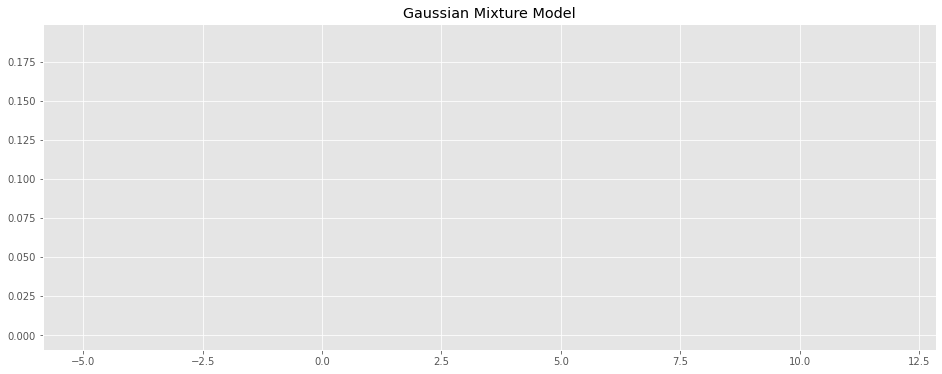

In [137]:
xx = np.linspace(-5, 12, 1000)
fig = plt.figure(figsize=(16, 6))

camera = Camera(fig)
for i in range(n_iter):
    #ground truth plot
    plt.title("Gaussian Mixture Model")
    plt.plot(xx, Gaussian_models[0].prob(xx) * true_pis[0], label="Gaussian distribution 1",color='skyblue')
    plt.plot(xx, Gaussian_models[1].prob(xx) * true_pis[1], label="Gaussian distribution 2",color='salmon')
    plt.plot(
        xx,
        (
            Gaussian_models[0].prob(xx) * true_pis[0]
            + Gaussian_models[1].prob(xx) * true_pis[1]
        ),
        label="Gaussian Mixture Model",
        ls="dashed",
        color="black",
        alpha=0.5,
    )
    plt.fill_betweenx(Gaussian_models[0].prob(xx) * true_pis[0], xx, color='skyblue', alpha=0.2)
    plt.fill_betweenx(Gaussian_models[1].prob(xx) * true_pis[1], xx, color='salmon', alpha=0.2)
    plt.vlines(x, 0, 0.005, color=np.array(["skyblue", "salmon"])[states])
    # update evaluation
    univariate_gmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=param_dict['pis'][i]),
    components_distribution=tfd.Normal(loc=param_dict['mus'][i], scale=param_dict['sigmas'][i]),
)
    plt.plot(
    xx, univariate_gmm.prob(xx), color='yellowgreen', label='EM evaluation', alpha=0.5
    )
    camera.snap()

#Creating the animation from captured frames
animation = camera.animate()

#Saving the animation
animation.save('EM-process.gif', writer = 'pillow')

